In [2]:
import os
import sys
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

parent_dir = os.path.abspath('..')
sys.path.append(parent_dir)

VARIABLE = 'st'

# Load the NetCDF file
file_path_st = f"results/forecast_horizons_st.nc"
st_data = xr.open_dataset(file_path_st)
file_path_sm = f"results/forecast_horizons_sm.nc"
sm_data = xr.open_dataset(file_path_sm)

station_id = "Condom"

st_data


<xarray.Dataset> Size: 331kB
Dimensions:            (t_init: 250, lead_time: 52, var: 3)
Coordinates:
  * t_init             (t_init) <U19 19kB '2022-02-01 00:00:00' ... '2022-04-...
  * lead_time          (lead_time) int64 416B 0 1 2 3 4 5 ... 46 47 48 49 50 51
  * var                (var) <U4 48B 'stl1' 'stl2' 'stl3'
Data variables:
    forecast_horizons  (t_init, lead_time, var) float64 312kB ...

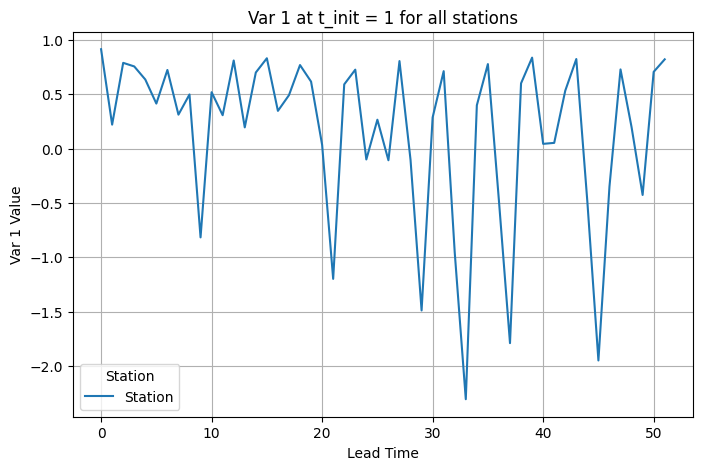

In [3]:
# Extract Var 1 at t_init = 1 for all stations and lead times
var_1_data = st_data["forecast_horizons"].sel(t_init='2022-02-01 00:00:00', 
                                             var=f"{VARIABLE}l1")

var_1_data

# Plot for all stations over lead times
plt.figure(figsize=(8, 5))
plt.plot(var_1_data.lead_time, var_1_data.data, label=f"Station")

plt.xlabel("Lead Time")
plt.ylabel("Var 1 Value")
plt.title("Var 1 at t_init = 1 for all stations")
plt.legend(title="Station")
plt.grid()
plt.show()


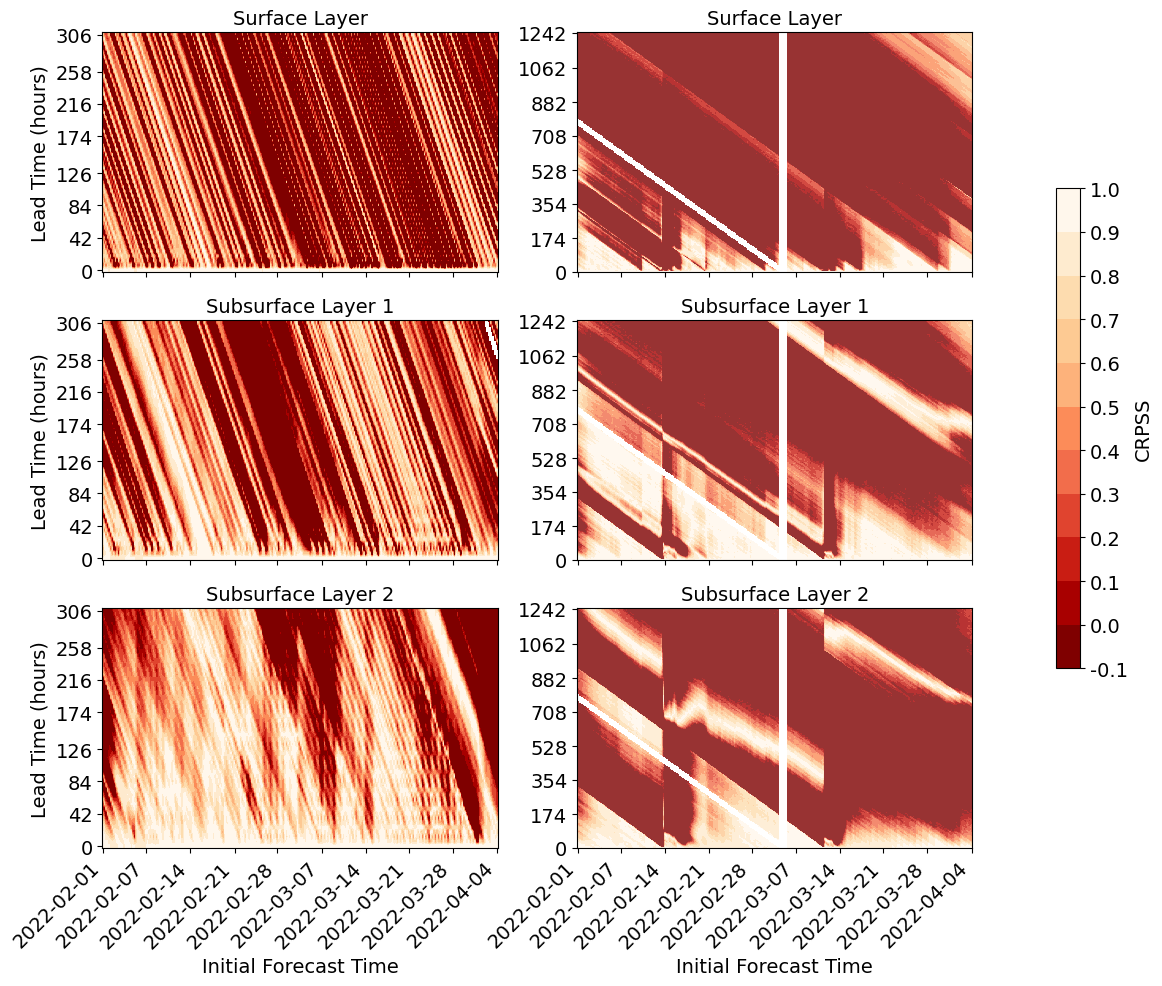

In [4]:
from matplotlib.colors import BoundaryNorm
import pandas as pd

st_1_avg = st_data["forecast_horizons"].sel(var=f"stl1")#.mean(dim="station")
st_2_avg = st_data["forecast_horizons"].sel(var=f"stl2")#.mean(dim="station")
st_3_avg = st_data["forecast_horizons"].sel(var=f"stl3")#.mean(dim="station")
sm_1_avg = sm_data["forecast_horizons"].sel(var=f"swvl1")#.mean(dim="station")
sm_2_avg = sm_data["forecast_horizons"].sel(var=f"swvl2")#.mean(dim="station")
sm_3_avg = sm_data["forecast_horizons"].sel(var=f"swvl3")#.mean(dim="station")

variables_st = [st_1_avg, st_2_avg, st_3_avg]
variables_sm = [sm_1_avg, sm_2_avg, sm_3_avg]
titles = ["Surface Layer", "Subsurface Layer 1", "Subsurface Layer 2"]

num_y_ticks = 8  

lead_time_range_st = np.arange(0, 52 * 6, 6)
lead_time_range_sm = np.arange(0, 52 * 6 *4, 6)
y_tick_positions_st = np.linspace(0, len(lead_time_range_st) - 1, num_y_ticks, dtype=int)
y_tick_labels_st = lead_time_range_st[y_tick_positions_st]
y_tick_positions_sm = np.linspace(0, len(lead_time_range_sm) - 1, num_y_ticks, dtype=int)
y_tick_labels_sm = lead_time_range_sm[y_tick_positions_sm]

var_t_init_st = pd.to_datetime(st_1_avg.t_init.values) 
var_t_init_sm = pd.to_datetime(sm_1_avg.t_init.values) 

cmap = plt.get_cmap("OrRd_r")
bounds = np.arange(-0.1, 1.05, 0.1)  # Creates intervals from 0.1 to 1.0
norm = BoundaryNorm(bounds, cmap.N)

plt.rcParams.update({'font.size': 14})

fig, axes = plt.subplots(3, 2, figsize=(12, 12), sharex=True)

for i, (st_var, sm_var, title) in enumerate(zip(variables_st, variables_sm, titles)):
    # Left column: ST
    ax_st = axes[i, 0]
    im_st = ax_st.imshow(st_var.T, aspect="auto", cmap=cmap, norm=norm, origin="lower")
    ax_st.set_title(title, size=14)
    ax_st.set_ylabel("Lead Time (hours)")

    # Set specific y-ticks for ST
    ax_st.set_yticks(y_tick_positions_st)
    ax_st.set_yticklabels(y_tick_labels_st)

    # Right column: SM
    ax_sm = axes[i, 1]
    im_sm = ax_sm.imshow(sm_var.T, aspect="auto", cmap=cmap, norm=norm, origin="lower", alpha=0.8)
    ax_sm.set_title(title.replace("(ST)", "(SM)"), size=14)

    # Set specific y-ticks for SM
    ax_sm.set_yticks(y_tick_positions_sm)
    ax_sm.set_yticklabels(y_tick_labels_sm)

# Convert var.t_init (xarray DataArray) to a datetime array
var_t_init_st = pd.to_datetime(var_t_init_st)
var_t_init_sm = pd.to_datetime(var_t_init_sm)

# Select 10 evenly spaced dates for x-axis labeling
num_x_ticks = 10
x_tick_positions_st = np.linspace(0, len(var_t_init_st) - 1, num_x_ticks, dtype=int)
x_tick_labels_st = [var_t_init_st[i].strftime("%Y-%m-%d") for i in x_tick_positions_st]

x_tick_positions_sm = np.linspace(0, len(var_t_init_sm) - 1, num_x_ticks, dtype=int)
x_tick_labels_sm = [var_t_init_sm[i].strftime("%Y-%m-%d") for i in x_tick_positions_sm]

axes[-1, 0].set_xlabel("Initial Forecast Time")
axes[-1, 0].set_xticks(x_tick_positions_st)
axes[-1, 0].set_xticklabels(x_tick_labels_st, rotation=45, ha="right")

axes[-1, 1].set_xlabel("Initial Forecast Time")
axes[-1, 1].set_xticks(x_tick_positions_sm)
axes[-1, 1].set_xticklabels(x_tick_labels_sm, rotation=45, ha="right")

# Adjust layout
fig.subplots_adjust(right=0.85, bottom=0.2)  # More space for rotated labels

# Create a single colorbar for all subplots
cbar_ax = fig.add_axes([0.92, 0.35, 0.02, 0.4])  # Adjust position and size
cbar = fig.colorbar(im_st, cax=cbar_ax, label="CRPSS", boundaries=bounds, ticks=bounds)
cbar.set_ticks(bounds)
cbar.set_ticklabels([f"{x:.1f}" for x in bounds])

# Save and show the plot
plt.savefig(f'plots/mc_ensemble_horizons_combined_condom.pdf')
plt.show()

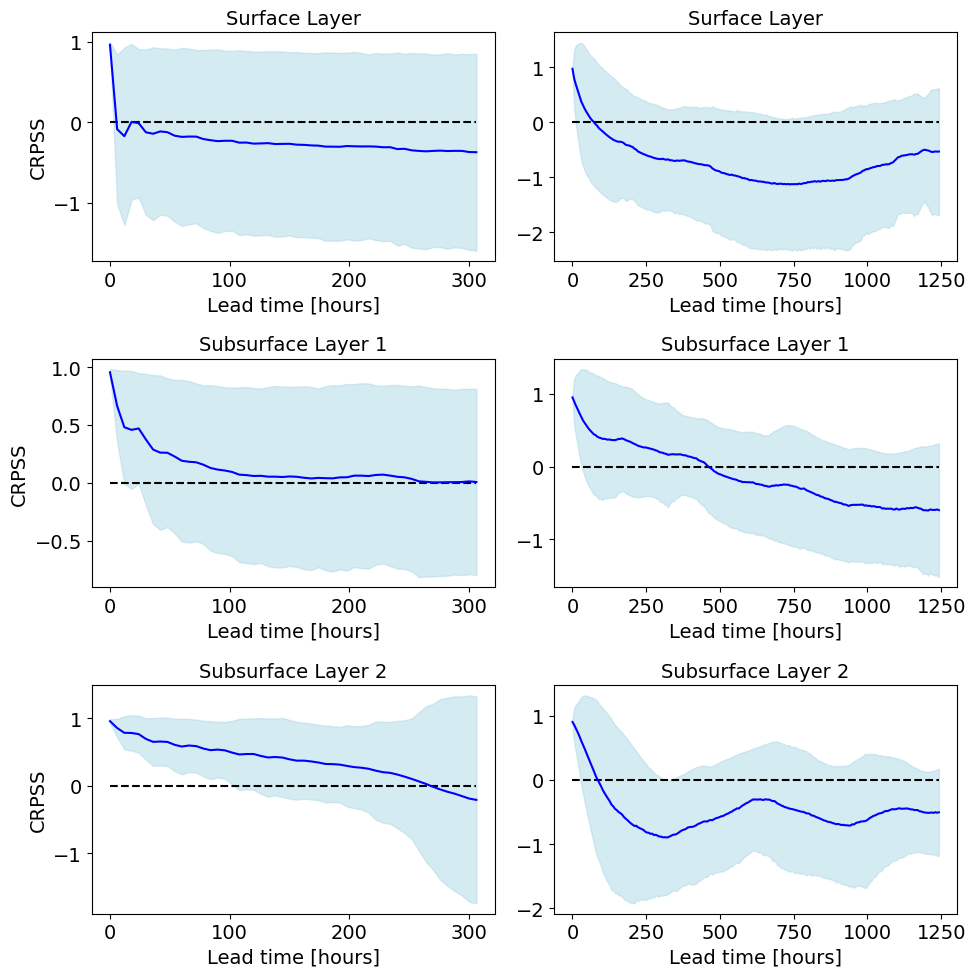

In [5]:
lead_time_range_st = np.arange(0, 52 * 6, 6)
lead_time_range_sm = np.arange(0, 52 * 6 *4, 6)


plt.rcParams.update({'font.size': 14})  # Change 14 to your desired font size

fig, axes = plt.subplots(3, 2, figsize=(10, 10), sharex=False)

for i, (st_var, sm_var, title) in enumerate(zip(variables_st, variables_sm, titles)):
    # Left column: ST
    ax_st = axes[i, 0]
    ax_st.hlines(y = 0, xmin=lead_time_range_st[0], xmax=lead_time_range_st[-1], linestyles="--", colors="black")
    ax_st.fill_between(
        lead_time_range_st,
        st_var.mean(axis=0) - st_var.std(axis=0),
        st_var.mean(axis=0) + st_var.std(axis=0),
        color="lightblue",
        alpha=0.5
    )
    ax_st.plot(lead_time_range_st, st_var.mean(axis=0), color="blue")
    ax_st.set_title(title, size=14)
    ax_st.set_ylabel("CRPSS")
    ax_st.set_xlabel("Lead time [hours]")

    # Right column: SM
    ax_sm = axes[i, 1]
    ax_sm.hlines(y = 0, xmin=lead_time_range_sm[0], xmax=lead_time_range_sm[-1], linestyles="--", colors="black")
    ax_sm.fill_between(
        lead_time_range_sm,
        sm_var.mean(axis=0) - sm_var.std(axis=0),
        sm_var.mean(axis=0) + sm_var.std(axis=0),
        color="lightblue",
        alpha=0.5
    )
    ax_sm.plot(lead_time_range_sm, sm_var.mean(axis=0), color="blue")
    ax_sm.set_title(title.replace("(ST)", "(SM)"), size=14)
    ax_sm.set_xlabel("Lead time [hours]")

# Adjust layout and show plot
plt.tight_layout()
plt.show()

/etc/ecmwf/ssd/ssd1/tmpdirs/pamw.6985.20250228_141730.295/ipykernel_214449/829923518.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


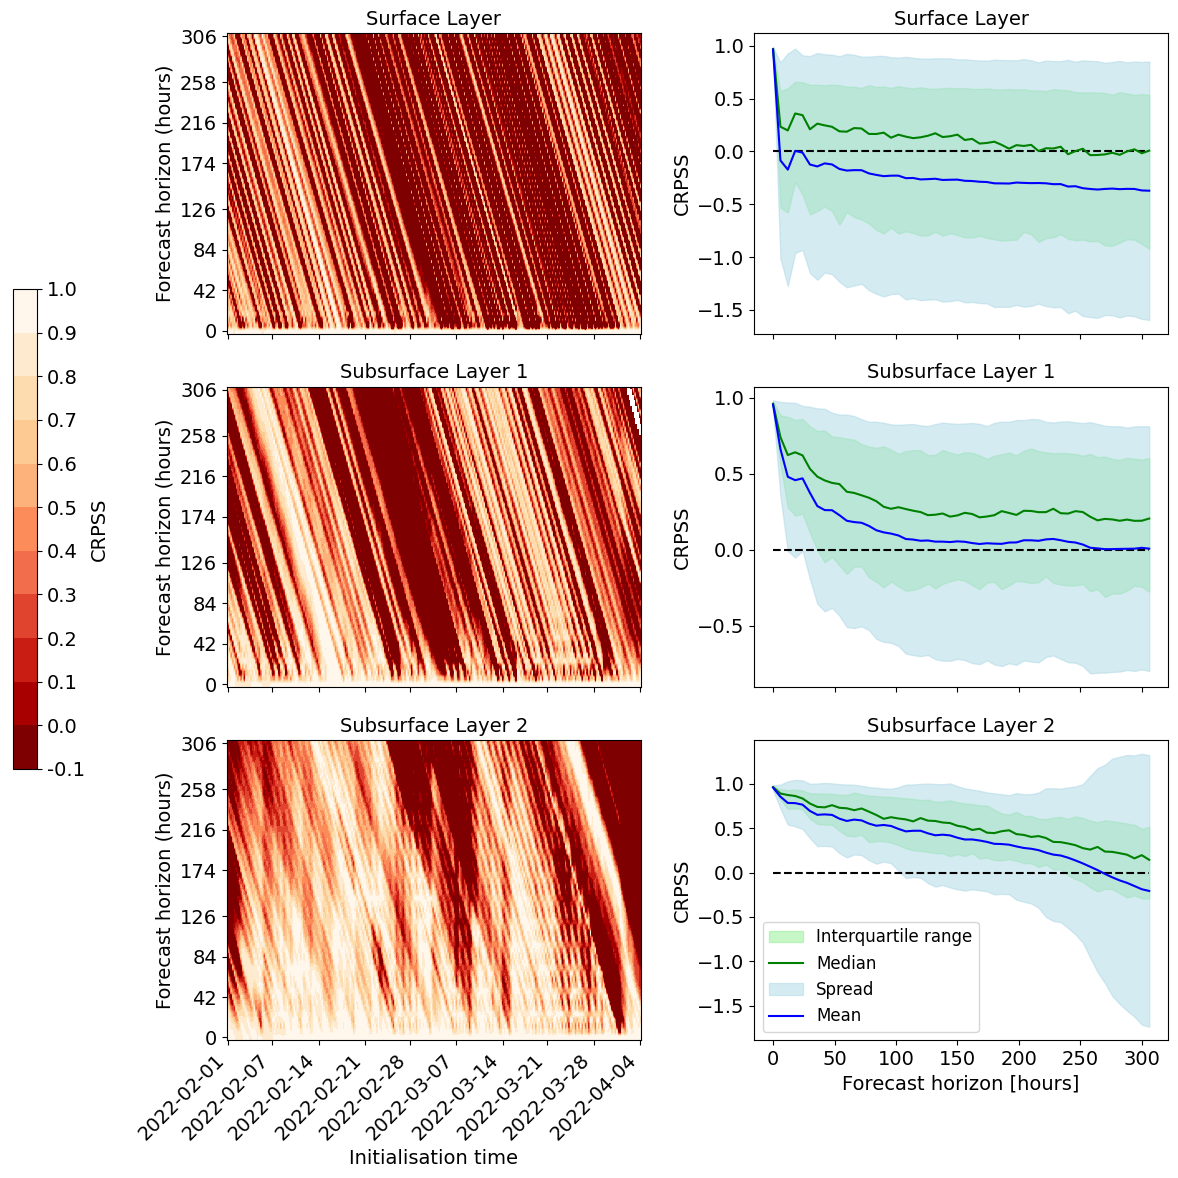

/etc/ecmwf/ssd/ssd1/tmpdirs/pamw.6985.20250228_141730.295/ipykernel_214449/829923518.py:116: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


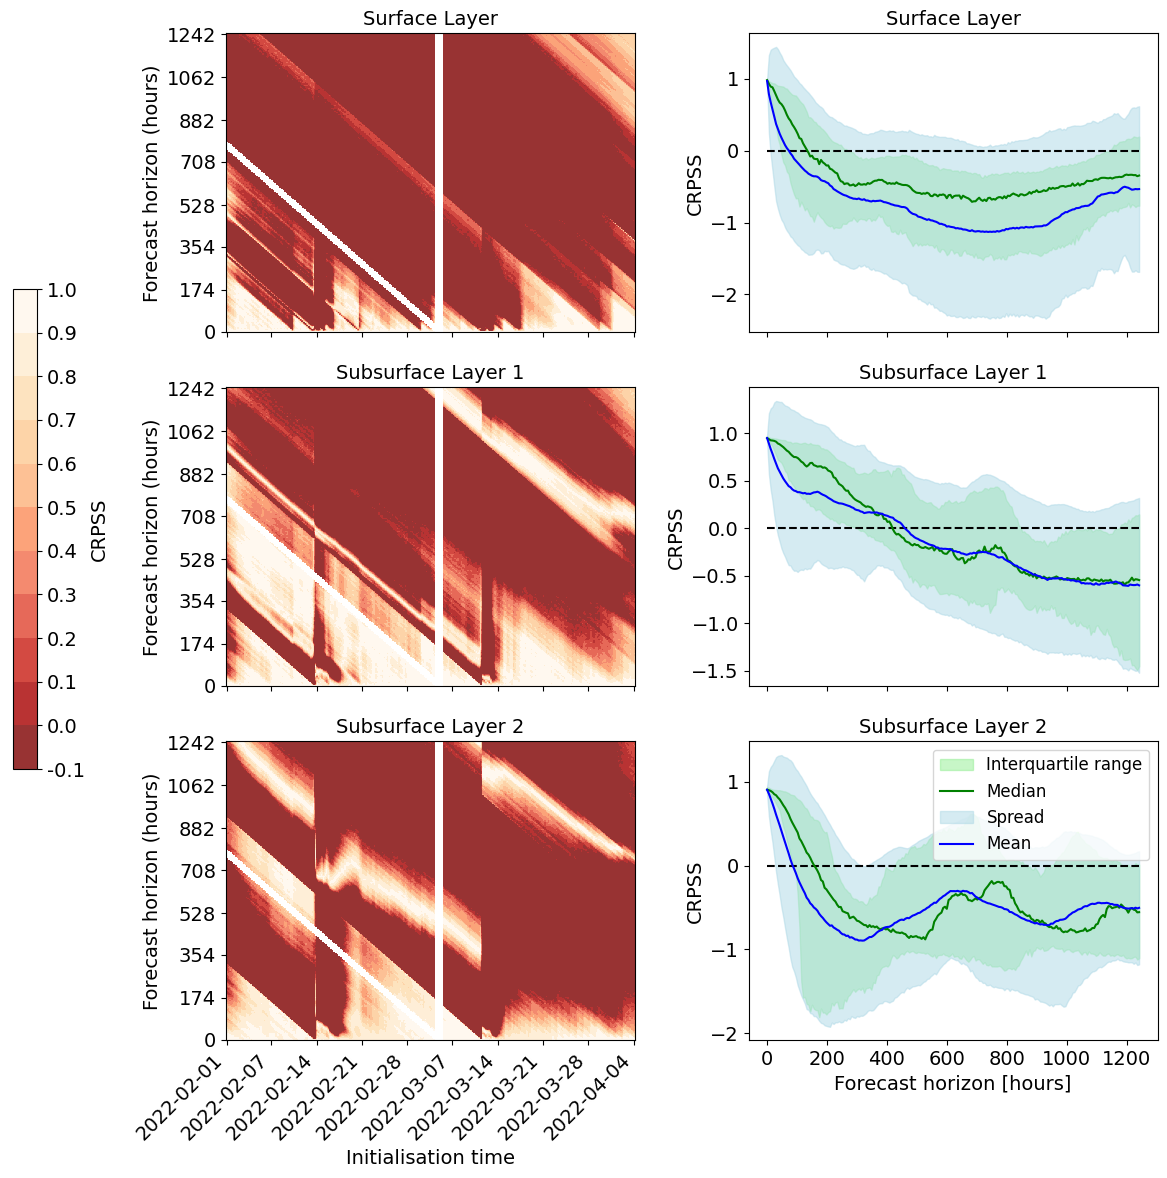

In [11]:
fig_st, axes_st = plt.subplots(3, 3, figsize=(12, 12), gridspec_kw={'width_ratios': [0.25, 1, 1]}, sharex='col')

for i, (st_var, title) in enumerate(zip(variables_st, titles)):

    axes_st[i, 0].axis("off")

    # Left column: Heatmap
    ax_heatmap = axes_st[i, 1]
    im_st = ax_heatmap.imshow(st_var.T, aspect="auto", cmap=cmap, norm=norm, origin="lower")
    ax_heatmap.set_title(title, size=14)
    ax_heatmap.set_yticks(y_tick_positions_st)
    ax_heatmap.set_yticklabels(y_tick_labels_st)

    ax_heatmap.set_ylabel("Forecast horizon (hours)")
    ax_heatmap.set_xticks(x_tick_positions_st)
    ax_heatmap.set_xticklabels(x_tick_labels_st, rotation=45, ha="right")

                       
    # Right column: Line Plot with Confidence Interval
    ax_line = axes_st[i, 2]
    ax_line.hlines(y=0, xmin=lead_time_range_st[0], xmax=lead_time_range_st[-1], linestyles="--", colors="black")
    ax_line.fill_between(
        lead_time_range_st,
        st_var.quantile(q=0.25, dim="t_init"),
        st_var.quantile(q=0.75, dim="t_init"),
        label="Interquartile range",
        color="lightgreen",
        alpha=0.5
    )
    ax_line.plot(lead_time_range_st, st_var.quantile(q=0.5, dim="t_init"), color="green", label="Median")
    ax_line.fill_between(
        lead_time_range_st,
        st_var.mean(axis=0) - st_var.std(axis=0),
        st_var.mean(axis=0) + st_var.std(axis=0),
        label="Spread",
        color="lightblue",
        alpha=0.5
    )
    ax_line.plot(lead_time_range_st, st_var.mean(axis=0), color="blue", label="Mean")
    ax_line.set_title(title, size=14)
    ax_line.set_ylabel("CRPSS")



axes_st[2, 1].set_xlabel("Initialisation time")
axes_st[2, 2].set_xlabel("Forecast horizon [hours]")
axes_st[2, 2].legend(loc="lower left", fontsize = 12)

# Add colorbar
cbar_ax_st = fig_st.add_axes([0.02, 0.35, 0.02, 0.4])
cbar_st = fig_st.colorbar(im_st, cax=cbar_ax_st, label="CRPSS", boundaries=bounds, ticks=bounds)
cbar_st.set_ticks(bounds)
cbar_st.set_ticklabels([f"{x:.1f}" for x in bounds])

plt.tight_layout()
plt.savefig(f'plots/mc_ensemble_horizons_st.pdf')
plt.show()

# ==============================
#   FIGURE 2: SM (Soil Moisture)
# ==============================

fig_sm, axes_sm = plt.subplots(3, 3, figsize=(12, 12), gridspec_kw={'width_ratios': [0.25, 1, 1]}, sharex='col')

for i, (sm_var, title) in enumerate(zip(variables_sm, titles)):
    # Left column: Heatmap
    axes_sm[i, 0].axis("off")

    ax_heatmap = axes_sm[i, 1]
    im_sm = ax_heatmap.imshow(sm_var.T, aspect="auto", cmap=cmap, norm=norm, origin="lower", alpha=0.8)
    ax_heatmap.set_title(title.replace("(ST)", "(SM)"), size=14)
    ax_heatmap.set_ylabel("Forecast horizon (hours)")

    ax_heatmap.set_yticks(y_tick_positions_sm)
    ax_heatmap.set_yticklabels(y_tick_labels_sm)

    ax_heatmap.set_xticks(x_tick_positions_sm)
    ax_heatmap.set_xticklabels(x_tick_labels_sm, rotation=45, ha="right")

    # Right column: Line Plot with Confidence Interval
    ax_line = axes_sm[i, 2]
    ax_line.hlines(y=0, xmin=lead_time_range_sm[0], xmax=lead_time_range_sm[-1], linestyles="--", colors="black")
    ax_line.fill_between(
        lead_time_range_sm,
        sm_var.quantile(q=0.25, dim="t_init"),
        sm_var.quantile(q=0.75, dim="t_init"),
        label="Interquartile range",
        color="lightgreen",
        alpha=0.5
    )
    ax_line.plot(lead_time_range_sm, sm_var.quantile(q=0.5, dim="t_init"), color="green", label="Median")

    ax_line.fill_between(
        lead_time_range_sm,
        sm_var.mean(axis=0) - sm_var.std(axis=0),
        sm_var.mean(axis=0) + sm_var.std(axis=0),
        color="lightblue",
        label = "Spread",
        alpha=0.5
    )
    ax_line.plot(lead_time_range_sm, sm_var.mean(axis=0), color="blue", label="Mean")
    ax_line.set_title(title.replace("(ST)", "(SM)"), size=14)
    ax_line.set_ylabel("CRPSS")

# Add colorbar
axes_sm[2, 1].set_xlabel("Initialisation time")
axes_sm[2, 2].set_xlabel("Forecast horizon [hours]")
axes_sm[2, 2].legend(loc="upper right", fontsize = 12)

# Add colorbar
cbar_ax_sm = fig_sm.add_axes([0.02, 0.35, 0.02, 0.4])
cbar_sm = fig_sm.colorbar(im_sm, cax=cbar_ax_sm, label="CRPSS", boundaries=bounds, ticks=bounds)
cbar_sm.set_ticks(bounds)
cbar_sm.set_ticklabels([f"{x:.1f}" for x in bounds])

plt.tight_layout()
plt.savefig(f'plots/mc_ensemble_horizons_sm.pdf')
plt.show()










In [19]:
for s_var in variables_st:
    
    print("ST Forecast horizon", np.argmax(s_var.mean(axis=0).values < 0))
    print("ST Forecast horizon std lower", np.argmax((s_var.mean(axis=0).values - s_var.std(axis=0).values) < 0))
    print("ST Forecast horizon std upper", np.argmax((s_var.mean(axis=0).values + s_var.std(axis=0).values) < 0))

for s_var in variables_sm:
    
    print("SM Forecast horizon", np.argmax(s_var.mean(axis=0).values < 0))
    print("SM Forecast horizon std lower", np.argmax((s_var.mean(axis=0).values - s_var.std(axis=0).values) < 0))
    print("SM Forecast horizon std upper", np.argmax((s_var.mean(axis=0).values + s_var.std(axis=0).values) < 0))

ST Forecast horizon 1
ST Forecast horizon std lower 1
ST Forecast horizon std upper 0
ST Forecast horizon 0
ST Forecast horizon std lower 2
ST Forecast horizon std upper 0
ST Forecast horizon 45
ST Forecast horizon std lower 18
ST Forecast horizon std upper 0
SM Forecast horizon 13
SM Forecast horizon std lower 2
SM Forecast horizon std upper 0
SM Forecast horizon 77
SM Forecast horizon std lower 6
SM Forecast horizon std upper 0
SM Forecast horizon 15
SM Forecast horizon std lower 5
SM Forecast horizon std upper 54
